In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from darts import TimeSeries
from darts.metrics import mape
from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import plot_residuals_analysis

import yfinance as yf

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [2]:
symbol = '^GSPC' # input
start = '2012-01-01' # input 
end = '2022-07-21'  # input
df = yf.download(symbol, start, end)

[*********************100%***********************]  1 of 1 completed


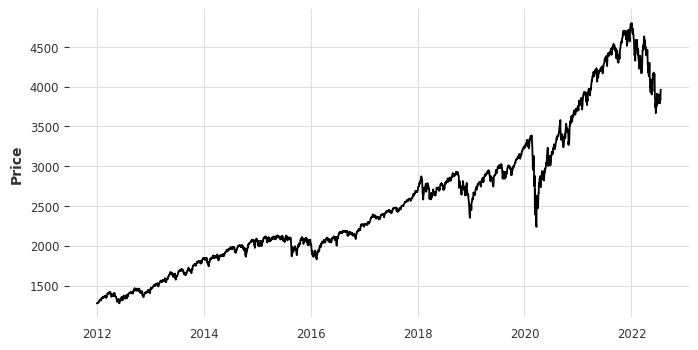

In [3]:
plt.figure(figsize=(8,4))
plt.plot(df['Close'])
plt.ylabel('Price')
plt.show()

In [4]:
dfm = df.resample('W').mean()
dfm.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-08,1273.530029,1282.059998,1266.389984,1278.307556,1278.307556,3.877268e+09
2012-01-15,1287.583984,1292.777979,1280.816016,1289.969971,1289.969971,3.854788e+09
2012-01-22,1301.607483,1310.494995,1299.612488,1307.897522,1307.897522,4.121290e+09
2012-01-29,1318.036011,1324.014014,1309.784009,1318.294019,1318.294019,4.080966e+09
2012-02-05,1318.517993,1328.523999,1313.481958,1323.990015,1323.990015,4.225678e+09


In [5]:
dfm = dfm.reset_index()
series = TimeSeries.from_dataframe(dfm, 'Date', 'Close')

In [6]:
#split into train and val
train, val = series[:-100], series[-100:]
print(len(dfm))
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

551


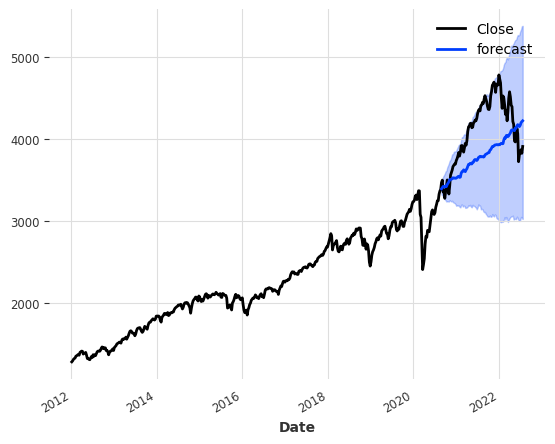

In [7]:
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [36]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())


model ExponentialSmoothing() obtains MAPE: 8.99%
model TBATS() obtains MAPE: 17.01%
model AutoARIMA() obtains MAPE: 11.61%
model Theta() obtains MAPE: 14.73%


  0%|          | 0/219 [00:00<?, ?it/s]

MAPE = 3.21%


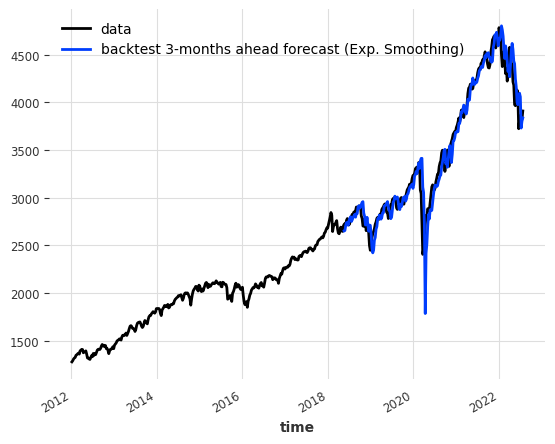

In [37]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-weeks ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

In [8]:
import darts
from darts import TimeSeries
from darts.metrics import mape
from darts.models import ExponentialSmoothing,TCNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import plot_residuals_analysis

In [9]:
prob_model = TCNModel(
    input_chunk_length=14*2,
    output_chunk_length=1,
    num_layers=2,
    dropout=0,
    likelihood=darts.utils.likelihood_models.GaussianLikelihood(),
    n_epochs=1500,
)

In [10]:
prob_model.fit(train.astype(np.float32))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 106   
----------------------------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


TCNModel(kernel_size=3, num_filters=3, num_layers=2, dilation_base=2, weight_norm=False, dropout=0, input_chunk_length=28, output_chunk_length=1, likelihood=<darts.utils.likelihood_models.GaussianLikelihood object at 0x28747cbd0>, n_epochs=1500)

In [11]:
pred = prob_model.predict(10, num_samples=100)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='Date'>

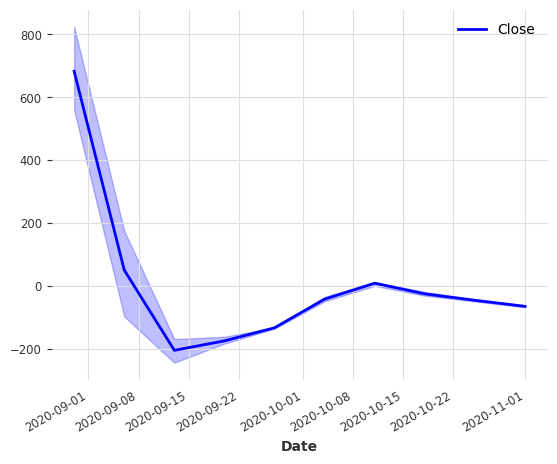

In [12]:
pred.plot(low_quantile=0.05, high_quantile=0.95, color='blue')

In [13]:
pred = prob_model.predict(75, num_samples=100)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='Date'>

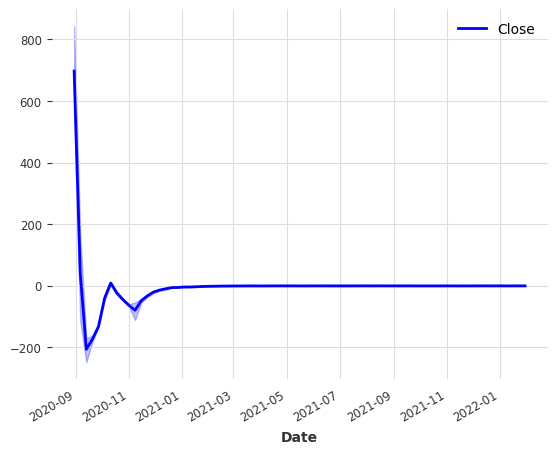

In [14]:
pred.plot(low_quantile=0.05, high_quantile=0.95, color='blue')